### ***Meeting the Dataset Requirement***


> Dataset Choice :

 I have decided to use CelebA dataset (https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), as it aligns with the dataset requirements description in PDF and provides desired 5 facial landmarks (left/right eye, nose tip and left/right mouth tip).


>  How annotations are structured ?

For each of 203k celebrity images we have annotations defined in `list_landmarks_align_celeba.csv` file as :

    `[lefteye_x, lefteye_y, righteye_x, righteye_y, nose_x, nose_y, leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y]








### *`Dataset Preparation Step 1 :  Getting the CelebA dataset`*





In [1]:
!pip install kaggle
from google.colab import files

# 1. Uploading my kaggle.json file & Setting up credentials
# you may need to upload kaggle.json file from your account to be able to run this
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 2. Downloading the CelebA dataset
!kaggle datasets download -d jessicali9530/celeba-dataset

# 3. Unzipping the dataset
!unzip celeba-dataset.zip -d /content/celeba



Streaming output truncated to the last 5000 lines.
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/celeba/img_alig



### *`Dataset Preparation Step 2 :  Getting ground-truth bbox labels`*

From `Model Outputs` section in the PDF, we can see that our model predicts bbox coordinates as well ==> so we also need ground-truth bbox labels for the model to train and learn !

As in the Dataset section it is not stated that we are given the bbox labels (it tells we have 5 landmarks), I have obtained the ***Ground-truth Bbox Labels*** to be used for the model by :


  1.   Parsing the given 10 landmark annotation coordinates.
  2.   Collecting them into x and y coordinates.
  3.   Difference between x_min and x_max will give the `width` of the bbox, while Difference between y_min and y_max will give the `height` of the bbox.
  4.  To make bbox wider (it is too tight), we pad by pad_ratio and update the width/height.
  5.  Finally, as Ultralytics model considers the x_center and y_center for bboxs, we obtain & normalize them

In [2]:
import os
import csv
from PIL import Image

def landmarks_to_bbox(row, img_width, img_height, pad_ratio=0.50):
    """
    Convert 10 facial landmark points into a padded bounding box in YOLO format.
    """

    # 1. Parsing the given 10 ladmark annotation coordinates.
    le_x = float(row['lefteye_x'])
    le_y = float(row['lefteye_y'])
    re_x = float(row['righteye_x'])
    re_y = float(row['righteye_y'])
    ns_x = float(row['nose_x'])
    ns_y = float(row['nose_y'])
    lm_x = float(row['leftmouth_x'])
    lm_y = float(row['leftmouth_y'])
    rm_x = float(row['rightmouth_x'])
    rm_y = float(row['rightmouth_y'])

    # 2. Collecting them into x and y oordinates.
    x_coords = [le_x, re_x, ns_x, lm_x, rm_x]
    y_coords = [le_y, re_y, ns_y, lm_y, rm_y]


    # 3. Difference between x_min and x_max will give the width of the bbox
    #    Difference between y_min and y_max will give the height of the bbox
    x_min = min(x_coords)
    x_max = max(x_coords)
    y_min = min(y_coords)
    y_max = max(y_coords)

    w = x_max - x_min
    h = y_max - y_min

    # 4. To make bbox wider (it is too tight), we pad by pad_ratio and update the width/height

    pad_x = pad_ratio * w
    pad_y = pad_ratio * h

    x_min_p = max(0.0, x_min - pad_x)
    y_min_p = max(0.0, y_min - pad_y)
    x_max_p = min(img_width, x_max + pad_x)
    y_max_p = min(img_height, y_max + pad_y)

    w_p = x_max_p - x_min_p
    h_p = y_max_p - y_min_p

    # 5. Finally, as Ultralytics model considers the x_center and y_center for bboxs, we obtain & normalize them
    cx_p = x_min_p + w_p / 2.0
    cy_p = y_min_p + h_p / 2.0

    x_center_norm = cx_p / img_width
    y_center_norm = cy_p / img_height
    w_norm = w_p / img_width
    h_norm = h_p / img_height

    return (x_center_norm, y_center_norm, w_norm, h_norm,
            (x_min_p, y_min_p, x_max_p, y_max_p),
            (le_x, le_y, re_x, re_y, ns_x, ns_y, lm_x, lm_y, rm_x, rm_y))


## ***Preparing the Labels for Training***

---

For Yolo model, we need to save a .txt file with our labels.


So, I have saved one .txt file for each image which contains :

`(class_id, bbox_coordinates, annotation_coordinates)`


*   class_id : `0` (face, so it is always 0)


*   bbox_coordinates are : `x_center_norm, y_center_norm, w_norm, h_norm`


*   annotation coordinates are : `le_x_norm, le_y_norm, re_x_norm, re_y_norm, ns_x_norm, ns_y_norm, lm_x_norm, lm_y_norm, rm_x_norm, rm_y_norm`

This will serve as our labels during YOLOv11 training !

In [ ]:

def convert_all(landmark_csv_path, img_dir, output_labels_dir, pad_ratio=0.20):
    """
    Reads all landmark entries, computes YOLO bounding boxes, and writes label files
    which will now contain bounding box + normalized landmark coords.
    """
    os.makedirs(output_labels_dir, exist_ok=True)

    # Count total rows
    with open(landmark_csv_path, newline='') as f_count:
        reader_count = csv.DictReader(f_count, delimiter=',')
        total = sum(1 for _ in reader_count)


    # Going through landmarks to get bbox + normalized annotations
    with open(landmark_csv_path, newline='') as f:
        reader = csv.DictReader(f, delimiter=',')
        processed = 0
        for row in reader:
            image_id = row.get('image_id')
            if image_id is None:
                processed += 1
                print(f"Skipped row {row} without valid image_id")
                continue

            img_path = os.path.join(img_dir, image_id)
            if not os.path.isfile(img_path):
                processed += 1
                print(f"Skipped row {row} — no image file at {img_path}")
                continue

            img = Image.open(img_path)
            img_width, img_height = img.size

            # computing bbox + raw landmark values
            xcn, ycn, wn, hn, _, (le_x, le_y, re_x, re_y, ns_x, ns_y, lm_x, lm_y, rm_x, rm_y) = landmarks_to_bbox(
                row, img_width, img_height, pad_ratio=pad_ratio
            )

            # normalized landmarks
            le_x_n, le_y_n = le_x / img_width, le_y / img_height
            re_x_n, re_y_n = re_x / img_width, re_y / img_height
            ns_x_n, ns_y_n = ns_x / img_width, ns_y / img_height
            lm_x_n, lm_y_n = lm_x / img_width, lm_y / img_height
            rm_x_n, rm_y_n = rm_x / img_width, rm_y / img_height

            # formalizing the labels file (.txt file) with (class_id, bbox_coord, annotation_coord)
            label_name = os.path.splitext(image_id)[0] + ".txt"
            label_path = os.path.join(output_labels_dir, label_name)

            with open(label_path, 'w') as lf:

                # class_id
                class_id = 0

                # bbox coordinates
                lf.write(f"{class_id} {xcn:.6f} {ycn:.6f} {wn:.6f} {hn:.6f}")


                # landmark coordinates
                lms = [
                    le_x_n, le_y_n,
                    re_x_n, re_y_n,
                    ns_x_n, ns_y_n,
                    lm_x_n, lm_y_n,
                    rm_x_n, rm_y_n
                ]

                for v in lms:
                    lf.write(f" {v:.6f}")
                lf.write("\n")

            processed += 1
            if processed % max(1, total // 10) == 0:
                pct = (processed / total) * 100
                print(f"Progress: {pct:.1f}% ({processed}/{total})")

    print("Conversion done. Labels (bbox + landmarks) written to:", output_labels_dir)

In [3]:
landmark_csv = "/content/celeba/list_landmarks_align_celeba.csv"
img_dir = "/content/celeba/img_align_celeba/img_align_celeba"
output_labels = "/content/celeba/YOLO_labels"

convert_all(landmark_csv, img_dir, output_labels, pad_ratio=0.5)

Progress: 10.0% (20259/202599)
Progress: 20.0% (40518/202599)
Progress: 30.0% (60777/202599)
Progress: 40.0% (81036/202599)
Progress: 50.0% (101295/202599)
Progress: 60.0% (121554/202599)
Progress: 70.0% (141813/202599)
Progress: 80.0% (162072/202599)
Progress: 90.0% (182331/202599)
Progress: 100.0% (202590/202599)
Conversion done. Labels (bbox + landmarks) written to: /content/celeba/YOLO_labels


## ***Label Visualization***
---

Here, I wanted to show some examples of the images with their landmark annotations (as red dots) and calculated bounding boxed (as green rectangles), to confirm that labels are correct before proceeding to training !

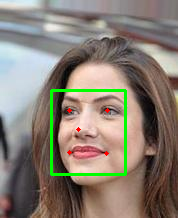

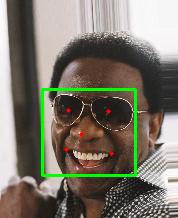

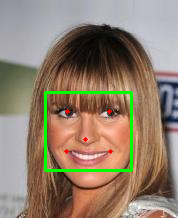

In [4]:
from google.colab import drive
import cv2
import os
from google.colab.patches import cv2_imshow
import pathlib

# defining image and label paths
IMG_DIR = pathlib.Path("/content/celeba/img_align_celeba/img_align_celeba")
LABELS_DIR = pathlib.Path("/content/celeba/YOLO_labels")


def plot_labels(img_path, lbl_path):

  # 1. reading image
  sample_image = cv2.imread(img_path)
  if sample_image is None:
    print("Image not found")
    return


  # 2. reading labels
  if not os.path.exists(lbl_path):
    print("Labels not found")
    return

  with open(lbl_path, 'r') as f:
    lines = f.readlines()

  for line in lines:
    label_data = line.strip().split()

    # first is class_idx
    cls = int(label_data[0])

    # then 1,2,3,4 are bbox coordinates
    # x_c, y_c, w, h
    xc, yc, bw, bh = map(float, label_data[1:5])

    # the remaining 10 are landmark annotations
    landmarks = list(map(float, label_data[5:]))


    h,w = sample_image.shape[:2]

    # denormalizing bbox
    x1 = int((xc - bw / 2) * w)
    y1 = int((yc - bh / 2) * h)
    x2 = int((xc + bw / 2) * w)
    y2 = int((yc + bh / 2) * h)

    # drawing bbox
    cv2.rectangle(sample_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # drawing the landmark annotations
    for i in range(0, len(landmarks), 2):
      x = int(landmarks[i] * w)
      y = int(landmarks[i+1] * h)
      cv2.circle(sample_image, (x, y), 2, (0, 0, 255), -1)

  # displaying the image
  cv2_imshow(sample_image)



# showing few images
sample_images = [f for f in os.listdir(IMG_DIR) if f.endswith((".jpg"))][:3]

for img_file in sample_images:
    img_path = os.path.join(IMG_DIR, img_file)
    lbl_path = os.path.join(LABELS_DIR, os.path.splitext(img_file)[0] + ".txt")
    plot_labels(img_path, lbl_path)

### ***Splitting the Daset for Train/Test/Val (80, 10, 10)***


---

The dataset was saved in the format provided by the Ultralytics :

My Yolo_dataset has :

- images
  - train (30 k images)
  - val (3750 images)
  - test (3750 images)

- labels
  - train (30k .txt files)
  - val (3750 .txt files)
  - test (3750 .txt files)

- dataset.yaml (with information about the paths, keypoints, classes)


The link for dataset/results is here : https://drive.google.com/drive/folders/1EKfZaLtOHYI7DSwC9FxFgcIjOw1Nfpk1?usp=drive_link

But, this dataset is when padding was 0.2, I have updated padding to 0.5 and trained with that dataset. I am currently uploading new dataset to Drive. The results/weights are also for dataset with padding of 0.5.



In [5]:
import pathlib
import random
import shutil

# Paths
IMG_DIR = pathlib.Path("/content/celeba/img_align_celeba/img_align_celeba")
LABELS_DIR = pathlib.Path("/content/celeba/YOLO_labels")
OUT_DIR = pathlib.Path("/content/YOLO_dataset")

# Desired counts
n_train = 30000
n_val = 3750
n_test = 3750


def build_subsets(img_dir, lbl_dir, out_dir, n_train, n_val, n_test):

  image_label_pairs = []

  images = sorted([i for i in img_dir.glob("*.jpg")])

  for image in images:
    label = lbl_dir / (image.stem + ".txt")
    if label.exists():
      image_label_pairs.append((image, label))

  print("Number of valid pairs:", len(image_label_pairs))


  random.seed(42)
  random.shuffle(image_label_pairs)

  # split
  train_pairs = image_label_pairs[:n_train]
  val_pairs = image_label_pairs[n_train:n_train + n_val]
  test_pairs = image_label_pairs[n_train + n_val:n_train + n_val + n_test]

  splits = {
        "train": train_pairs,
        "val": val_pairs,
        "test": test_pairs
    }

  for split, pairs in splits.items():
    (out_dir / "images" / split).mkdir(parents=True, exist_ok=True)
    (out_dir / "labels" / split).mkdir(parents=True, exist_ok=True)

    for (img,lbl) in pairs:
      shutil.copy2(img, out_dir / "images" / split / img.name)
      shutil.copy2(lbl, out_dir / "labels" / split / lbl.name)

  for split in splits:
    count_images = len(list((out_dir / "images" / split).glob("*.jpg")))
    count_labels = len(list((out_dir / "labels" / split).glob("*.txt")))
    print(f"{split}: {count_images} images, {count_labels} labels")


build_subsets(IMG_DIR, LABELS_DIR, OUT_DIR, n_train, n_val, n_test)

Number of valid pairs: 202599
train: 30000 images, 30000 labels
val: 3750 images, 3750 labels
test: 3750 images, 3750 labels


## ***Model Initialization and Training pipeline***



---


I have initalized the model and trained using simple script provided for the training in their website. But here are some key notes :


1.   The activation function was changed to ReLu as requested.
2.   Model was trained for `50 epochs` and using `batch_size = 16`. I did not have GPU, that is why I have used Colab provided `L4 GPU` and it took me `3.25 hours` to train for 50 epochs.
3. I have used the `Yolov11 pose weights` rather than detection weights, because they are trained for keypoint regression in addition to bbox. So I think, if finetuned on our dataset, it can better predict the face landmarks than the detection variant. Idea : As it knows, how to predict the points/poses, it will just need to adapt to face landmarks.

---

Losses after 50 epochs :

        *   BOUNDING BOXES : `bbox_loss = 0.2798`
        *   CONFIDENCES : `cls_loss = 0.1262`
        *   LANDMARKS : `pose_loss = 0.01123`



And mAP are quite high I think ~ 0.95. (you can see below.)



In [6]:
# installing Ultralytics
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.8 MB/s eta 0:00:00


In [10]:
from ultralytics.nn.modules import Conv
import torch.nn as nn
from ultralytics import YOLO

# replacing default SiLU with ReLU
Conv.default_act = nn.ReLU()

# loading the model
model = YOLO("yolo11n-pose.pt")

# training the model
results = model.train(
    data="/content/YOLO_dataset/dataset.yaml",
    epochs=50,
    imgsz=640,
    batch=16
)


Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/YOLO_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-pose.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots

## ***Running Inference on random 5 test images***

I have more reuslts in Google Drive as well as the weights :

https://drive.google.com/drive/folders/1EKfZaLtOHYI7DSwC9FxFgcIjOw1Nfpk1?usp=drive_link


0: 640x544 1 face, 17.8ms
1: 640x544 1 face, 17.8ms
2: 640x544 1 face, 17.8ms
3: 640x544 1 face, 17.8ms
4: 640x544 1 face, 17.8ms
Speed: 1.7ms preprocess, 17.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)
Results saved to /content/runs/pose/predict6


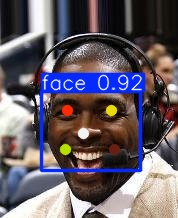

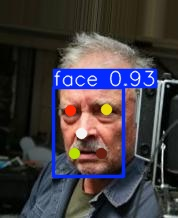

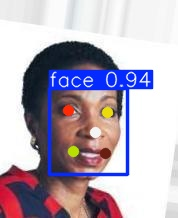

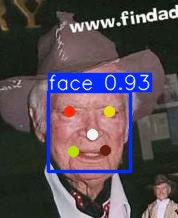

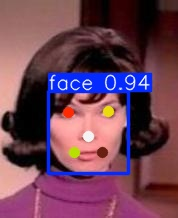

In [20]:
from ultralytics import YOLO
import glob
from IPython.display import Image, display

# Loading our trained model
model = YOLO("runs/pose/train4/weights/best.pt")

# Picking 5 test images
test_images = glob.glob("/content/YOLO_dataset/images/test/*.jpg")[:5]

# Running inference and saving predictions
results = model.predict(source=test_images, save=True, imgsz=640)
save_dir = results[0].save_dir

# Displaying the saved prediction images
for img_path in pathlib.Path(save_dir).glob("*.jpg"):
    display(Image(filename=img_path))
